In [2]:
from fastai import *
from fastai.imports import *
from fastai.vision import *
from fastai.callbacks import *
import matplotlib.pyplot as plt
from pathlib import Path
from efficientnet_pytorch import EfficientNet

%matplotlib inline

In [3]:
seed = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed)

In [4]:
path = Path("../../task1/photos")
model_name = "eff_b0"
bs=16
img_size=224
path.ls()
tfms = get_transforms(flip_vert=False,p_affine=0,max_lighting=0.4,max_rotate=5)

In [5]:
path.ls()

[PosixPath('../../task1/photos/train'),
 PosixPath('../../task1/photos/holdout'),
 PosixPath('../../task1/photos/test'),
 PosixPath('../../task1/photos/models')]

In [6]:
data = ImageDataBunch.from_folder(path, train="train", valid='test', test='holdout',
                                  ds_tfms=tfms, size=img_size, num_workers=16,
                                  bs=bs, seed=seed).normalize(imagenet_stats)

In [7]:
model = EfficientNet.from_pretrained('efficientnet-b0',num_classes=2)

Loaded pretrained weights for efficientnet-b0


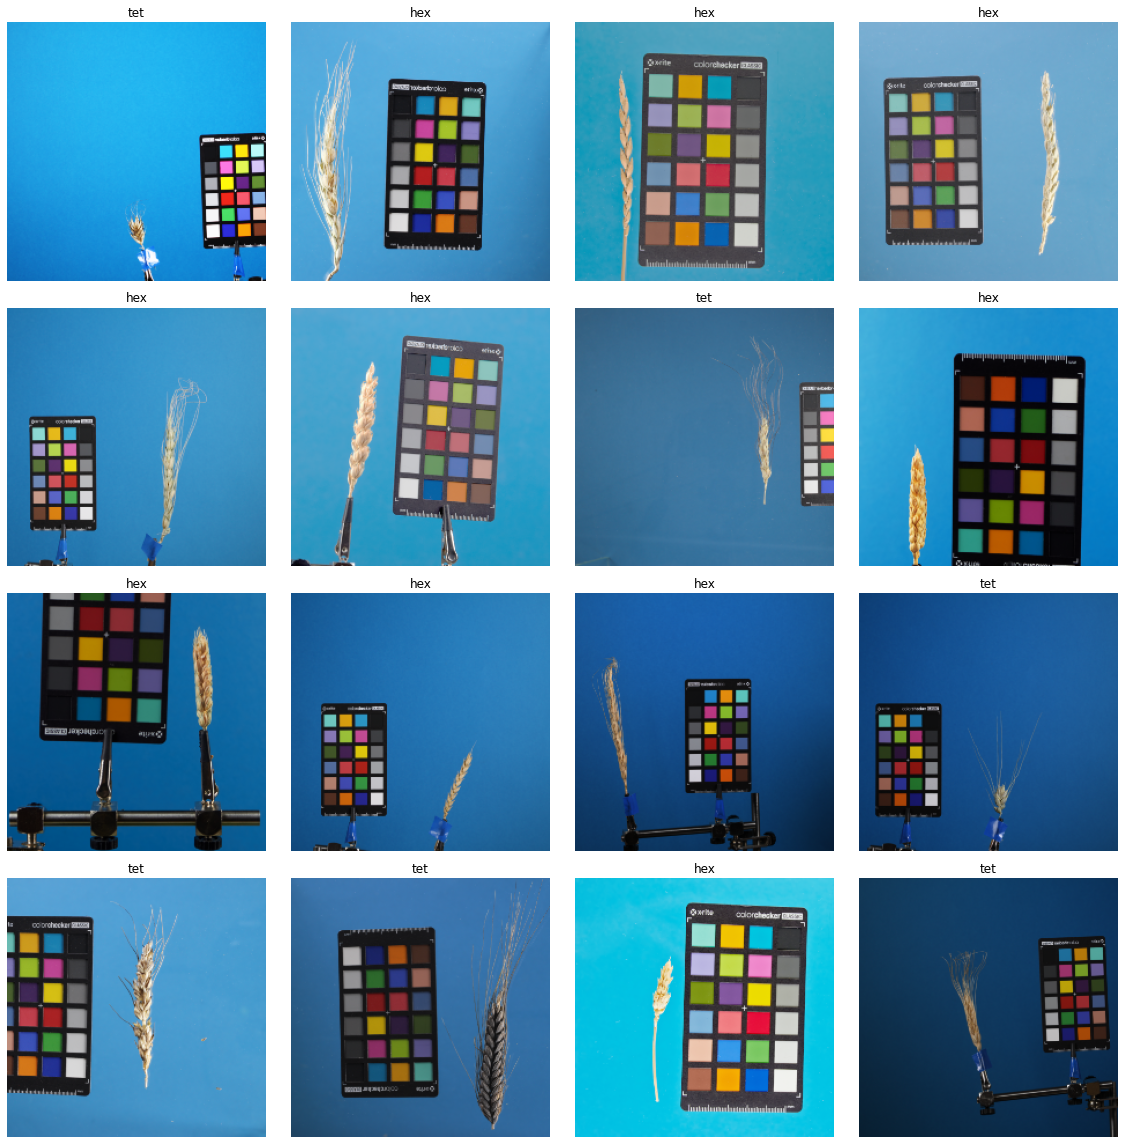

In [8]:
data.show_batch()

In [118]:
data.classes

['hex', 'tet']

In [10]:
learn = Learner(data, model,
                path='models', model_dir=model_name,
                metrics=[error_rate,accuracy,AUROC()],
                callback_fns=[partial(SaveModelCallback, every='improvement', monitor='auroc', name='best_auroc')]
               ).to_fp16()
learn.save('best_auroc')

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 3.02E-04


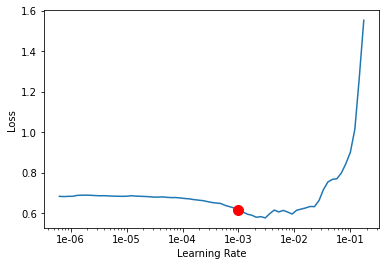

In [11]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [115]:
Learner

fastai.basic_train.Learner

In [13]:
learn.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.338816,0.318948,0.166159,0.833841,0.983435,04:28
1,0.217304,0.216185,0.068598,0.931402,0.985509,03:52
2,0.191037,0.803874,0.185976,0.814024,0.938437,03:53
3,0.151033,0.302891,0.094512,0.905488,0.984082,03:53
4,0.129777,0.129763,0.033537,0.966463,0.991849,03:52
5,0.055211,0.029142,0.012195,0.987805,0.999484,03:53
6,0.040603,0.022327,0.012195,0.987805,0.999757,03:52
7,0.031265,0.029347,0.009146,0.990854,0.999542,03:53
8,0.012224,0.029962,0.007622,0.992378,0.999649,03:52
9,0.006564,0.028860,0.010671,0.989329,0.999562,03:53


Better model found at epoch 0 with auroc value: 0.9834345579147339.
Better model found at epoch 1 with auroc value: 0.9855089783668518.
Better model found at epoch 4 with auroc value: 0.991848886013031.
Better model found at epoch 5 with auroc value: 0.9994838237762451.
Better model found at epoch 6 with auroc value: 0.9997565746307373.


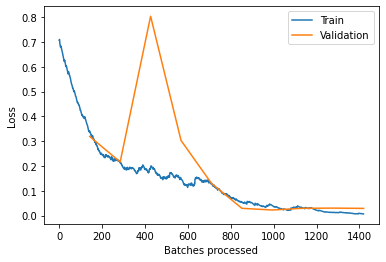

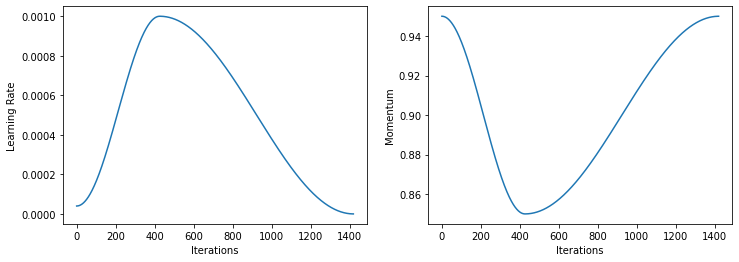

In [14]:
learn.save('stage-1')
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)

In [44]:
# learn.recorder.plot(suggestion=True)

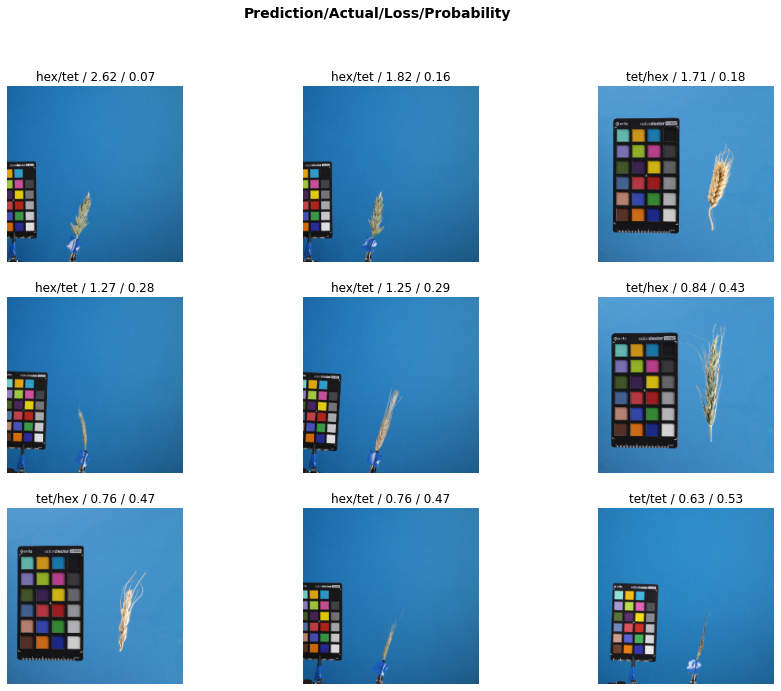

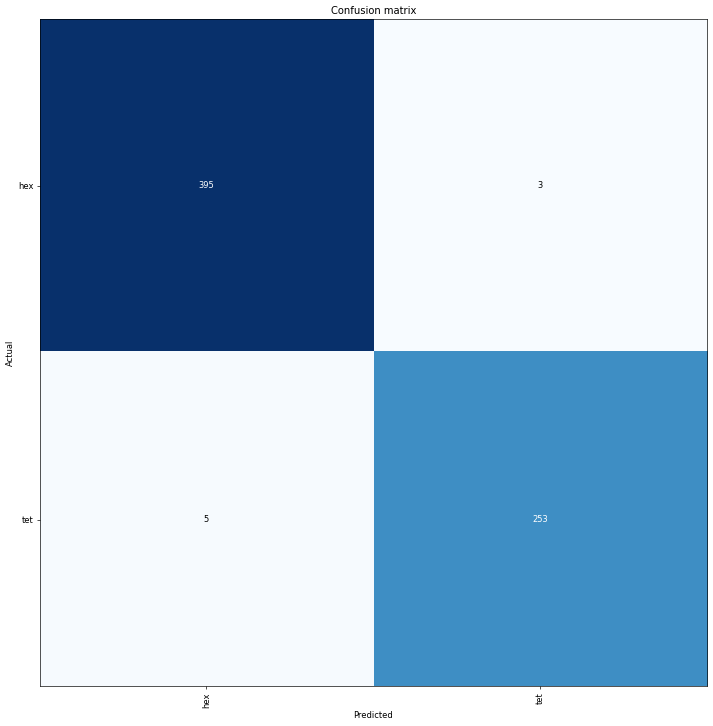

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [90]:
learn.export('model_1.pkl')

In [119]:
conv_learner = learn.to_fp32()
conv_learner.export('efficientnet-b0-224-fp32.pkl')

In [120]:
model_dir = "models"
model_name = "efficientnet-b0-224-fp32.pkl"
path = Path("../../task1/photos")

learn = load_learner(model_dir,model_name)

In [121]:
img_size=224
seed = 42
tfms = get_transforms(flip_vert=False,p_affine=0,max_lighting=0.4,max_rotate=5)

In [122]:
data = ImageDataBunch.from_folder(path,  test='holdout',
                                  ds_tfms=tfms, size=img_size, num_workers=16,
                                  seed=seed).normalize(imagenet_stats)

/opt/tljh/user/lib/python3.7/site-packages/fastai/data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [172]:
from tqdm import tqdm

df = pd.DataFrame(columns=['target','img','pred','hex','tet'])
num = len(data.test_ds)
for i in tqdm(range(num)):
    target = filename = str(data.test_ds.items[i]).split('/')[-2]
    filename = str(data.test_ds.items[i]).split('/')[-1]
    predict = learn.predict(data.test_ds[i][0])
    df.loc[i] = [ target, filename, str(predict[0]), to_np(predict[2][0]), to_np(predict[2][1]) ]
df

100%|██████████| 656/656 [02:47<00:00,  3.91it/s]


,target,img,pred,hex,tet
0,tet,7897_3_{X-14}.jpg,tet,3.053436e-05,0.9999695
1,tet,7618_4_{II-17}.jpg,tet,2.5149113e-06,0.9999975
2,tet,8364_1_{X-14}.jpg,tet,0.0046575856,0.9953425
3,tet,8663_4_{X-14}.jpg,tet,0.00021522914,0.99978477
4,tet,7894_3_{X-14}.jpg,tet,0.00012312212,0.99987686
...,...,...,...,...,...
651,hex,7792_2_{IX-18}.jpg,hex,0.9996113,0.00038869889
652,hex,6527_4.jpg,hex,1.0,5.840186e-08
653,hex,6937_2.jpg,hex,0.99999845,1.5860833e-06
654,hex,8798_2.jpg,hex,0.9998068,0.00019320323


In [173]:
from sklearn.metrics import accuracy_score

accuracy_score(df.target,df.pred)

0.9878048780487805

In [174]:
df.loc[df['target'] == 'hex', 'target'] = 1
df.loc[df['target'] == 'tet', 'target'] = 0

df.loc[df['pred'] == 'hex', 'pred'] = 1
df.loc[df['pred'] == 'tet', 'pred'] = 0

y = df['target'].astype(int)
pr = df['pred'].astype(int)


In [178]:
p_y = df['hex']
for i in range(len(df['hex'])):
    if pr[i] == 0:
        p_y[i] = 1 - df['tet'][i]
       

In [179]:
p_y

0      3.05176e-05
1       2.5034e-06
2       0.00465751
3      0.000215232
4      0.000123143
          ...     
651      0.9996113
652            1.0
653     0.99999845
654      0.9998068
655     0.99998593
Name: hex, Length: 656, dtype: object

In [180]:
from sklearn.metrics import roc_auc_score

y = df['target'].astype(int)
pr = p_y.astype(float)
roc_auc_score(y, pr)

0.9953472866419294